In [6]:
import os
import numpy as np
import pandas as pd
import torch
import random

from utils import seed_everything,data_load

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
DATA_PATH = '../EDA/'

In [3]:
class CFG:
    START_IDX = 90000000
    SEED = 42
    TEST_SIZE = 0.2
    N_EPOCHS = 5
    BATCH_SZ = 1024
    PATIENCE = 3
    VIRTUAL_BS = 128
    LR = 0.01
    ND = 8  # Width of the decision prediction layer. Bigger values gives more capacity to the model with the risk of overfitting. 
    NA = 8  # Width of the attention embedding for each mask. According to the paper n_d=n_a is usually a good choice. 
    N_STEPS = 3 # Number of steps in the architecture (usually between 3 and 10)
    GAMMA = 1.3 # This is the coefficient for feature reusage in the masks. A value close to 1 will make mask selection least correlated between layers. 
    #Values range from 1.0 to 2.0.
    N_INDEPENDENT = 1 # Number of independent Gated Linear Units layers at each step. Usual values range from 1 to 5.
    LAMBDA = 0
    N_SHARED = 3 # Number of shared Gated Linear Units at each step Usual values range from 1 to 5
    MOMENTUM = 0.1
    CLIP = 1.0
    MASK_TYPE = 'sparsemax' #(default='sparsemax') Either "sparsemax" or "entmax" : this is the masking function to use for selecting features

In [21]:
def feature_engineering(df):
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df.sort_values(by=['userID','Timestamp'], inplace=True)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    ## 유저별 맞춘 개수를 한칸 아래로 땡기기(shift 1)
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    ## 유저별 문제 푼 개수 cumcount
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    # 유저별 푼 문제수에 따른 정확도
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    
    ## 시험지별 정답률과 맞춘 횟수
    correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
    correct_t.columns = ["test_mean", 'test_sum']
    ## 문제 유형별 정답률과 맞춘 횟수
    correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
    correct_k.columns = ["tag_mean", 'tag_sum']

    ## df에 시험지별 정답률과 맞춘 횟수 추가
    df = pd.merge(df, correct_t, on=['testId'], how="left")
    ## df에 문제 유형별 정답률과 맞춘 횟수 추가
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    
    return df

In [7]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
def custom_train_test_split(df, ratio=0.7, split=True):
    
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [33]:
seed_everything(CFG.SEED)
train,test = data_load(DATA_PATH)
train = feature_engineering(train)
train,valid = custom_train_test_split(train)

In [34]:
train.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'Time', 'Timediff', 'Timepassed', 'assess_count',
       'user_correct_answer', 'user_total_answer', 'user_acc', 'test_mean',
       'test_sum', 'tag_mean', 'tag_sum'],
      dtype='object')

In [36]:
FEATS = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 'Time','Timediff','Timepassed','assess_count',
         'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum','answerCode']
train = train[FEATS]
valid = valid[FEATS]


In [28]:
model = TabNetClassifier(
    n_d = CFG.ND,
    n_a = CFG.NA,
    n_steps = CFG.N_STEPS,
    gamma = CFG.GAMMA, 
    n_independent = CFG.N_INDEPENDENT,
    n_shared = CFG.N_SHARED,
    # cat_dims=[cat_dims],
    cat_emb_dim=1,
    optimizer_params=dict(lr=CFG.LR),
    momentum=CFG.MOMENTUM,
    # cat_idxs=[cat_idxs],
    verbose=1,
    #scheduler_params=dict(milestones=[20, 50, 80], gamma=0.5), 
    #scheduler_fn=torch.optim.lr_scheduler.MultiStepLR,
    mask_type = CFG.MASK_TYPE,
    lambda_sparse = CFG.LAMBDA,
    clip_value = CFG.CLIP
)

/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [42]:
train = train.fillna(0)
valid = valid.fillna(0)

In [43]:
model.fit(
    X_train = train.drop(columns = 'answerCode').values,
    y_train = train['answerCode'].values,
    eval_set = [(valid.drop(columns = 'answerCode').values,valid['answerCode'].values)],
    max_epochs = CFG.N_EPOCHS, 
    patience = CFG.PATIENCE,
    batch_size = CFG.BATCH_SZ, 
    virtual_batch_size = CFG.VIRTUAL_BS,
    num_workers = 0,
    weights = 1,
    drop_last = False
)

epoch 0  | loss: 0.61077 | val_0_auc: 0.67882 |  0:01:51s
epoch 1  | loss: 0.59891 | val_0_auc: 0.67944 |  0:03:35s
epoch 2  | loss: 0.58436 | val_0_auc: 0.68425 |  0:05:14s
epoch 3  | loss: 0.58189 | val_0_auc: 0.68216 |  0:07:09s
epoch 4  | loss: 0.58011 | val_0_auc: 0.68021 |  0:09:00s
Stop training because you reached max_epochs = 5 with best_epoch = 2 and best_val_0_auc = 0.68425


/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [44]:
# save tabnet model
saving_path_name = "./saved/tabnet_model_test_1"
saved_filepath = model.save_model(saving_path_name)

# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

Successfully saved model at ./saved/tabnet_model_test_1.zip


/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [63]:
explain = loaded_clf.explain(valid.drop(columns = 'answerCode').values)

In [67]:
explain[0].shape

(12,)

In [72]:
train.columns

Index(['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 'Time',
       'Timediff', 'Timepassed', 'assess_count', 'user_acc', 'test_mean',
       'test_sum', 'tag_mean', 'tag_sum', 'answerCode'],
      dtype='object')

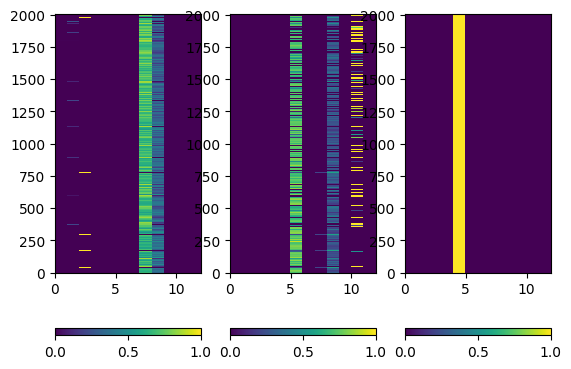

In [91]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,3)

for i,ax in enumerate(axes):
    pcm = ax.pcolor(explain[1][i],vmin = 0, vmax = 1)
    cbar = fig.colorbar(pcm, ax=axes[i], 
                        ticks=[0, 0.5, 1], 
                        orientation='horizontal'
                       )